In [42]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm
from scipy import signal

In [43]:
# Experiments to process
experiment_ids = ['historical', 'ssp370']
experiment_ids1 = ['historical']

# Seasons to process
seasons = ['all','DJF','JJA']

# Time slices (future) to process
time_slices = ([['1991','2020'],
                ['2001','2030'],
                ['2011','2040'],
                ['2021','2050'],
                ['2031','2060'],
                ['2041','2070'],
                ['2051','2080'],
                ['2061','2090'],
                ['2071','2100']])

In [44]:
# Read data locations
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

In [45]:
# Subset to monthly precipitation (let's just look at one run per model for now)
df_mon_pr = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'pr')
                 & (df.member_id == "r1i1p1f1"))])

In [46]:
# Get names of all the models in the subset
pr_source_ids = []
for name, group in df_mon_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        pr_source_ids.append(name)

In [47]:
# Subset to monthly tas (let's just look at one run per model for now)
df_mon_tas = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'tas')
                 & (df.member_id == "r1i1p1f1"))])

In [48]:
# Get names of all the models in the subset
tas_source_ids = []
for name, group in df_mon_tas.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        tas_source_ids.append(name)

In [49]:
# Get names of all the models in the subset
df_areacella = (df[((df.table_id == 'fx') 
                 & (df.variable_id == 'areacella')
                 & (df.member_id == "r1i1p1f1"))])

areacella_source_ids = []
for name, group in df_areacella.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids1]):
        areacella_source_ids.append(name)
areacella_source_ids

['CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'E3SM-1-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC6',
 'MRI-ESM2-0',
 'SAM0-UNICON']

In [50]:
tas_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [51]:
pr_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'FGOALS-g3',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [52]:
source_ids=list(set(tas_source_ids).intersection(pr_source_ids))
source_ids

['CESM2',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'IPSL-CM6A-LR',
 'MIROC6',
 'BCC-CSM2-MR',
 'MRI-ESM2-0',
 'CESM2-WACCM',
 'CanESM5',
 'GFDL-ESM4']

In [53]:
source_ids_areacella=list(set(tas_source_ids).intersection(pr_source_ids).intersection(areacella_source_ids))
source_ids_areacella

['CESM2-WACCM',
 'CESM2',
 'MIROC6',
 'MRI-ESM2-0',
 'IPSL-CM6A-LR',
 'CanESM5',
 'GFDL-ESM4']

In [54]:
# Function to load data: df_data has the catalogue of the variable of interest
def load_data(df_data, source_id, expt_id):
    """
    Load data for given variable, source and expt ids.
    """
    uri = df_data[(df_data.source_id == source_id) &
                  (df_data.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [55]:
def spatial_average(field,lat_or_spatial_weights,latitude):
    if lat_or_spatial_weights is not None:
        field_mean = np.average(field,weights=lat_or_spatial_weights.areacella)
    else:
        # Use the cosine of the converted latitudes as weights for the average
        field_mean = np.average(field.mean("lon"),weights=np.cos(np.deg2rad(latitude)))
    return field_mean

In [85]:
# Function to get mean and variability and their changes
def mean_variable_calc(data_tmp, var_name, seas='all', weights_in=None):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
       
    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'][var_name].sel(time=data_tmp['hist'].time.dt.season.isin(seas)).mean('time'))
    mu_futr = (data_tmp['futr'][var_name].sel(time=data_tmp['futr'].time.dt.season.isin(seas)).mean('time'))

    # Take the spatial average 
    latitude=data_tmp['hist'].lat
    mu_histG = spatial_average(mu_hist,weights_in,latitude)
    mu_futrG = spatial_average(mu_futr,weights_in,latitude)
        
    #dvarG = mu_futrG-mu_histG

    # Out 
    outp = xr.Dataset(
        data_vars = {'mu_histG':    ([],mu_histG),
                    'mu_futrG':    ([],mu_futrG)}
        )


    return(outp)

In [ ]:
tdata = {}
tresults = {}

for mod_name in tqdm(source_ids):
    print('\n\nStarting '+mod_name+'\n')
    ds_hist = load_data(df_mon_tas, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
    ds_ssp  = load_data(df_mon_tas, mod_name, experiment_ids[1])

    try: # try getting areacella data
        ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

    except: #if not available, flag it as 0. It will use np.cos(lat)
        ds_areacella = None

    tdata[mod_name] = {}
    tresults[mod_name] = {}

    for time_slice in time_slices:
        print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
        if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
            print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
            break

        # Get corresponding temporal slice of data and stage it
        ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
        tdata[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}


        tresults[mod_name]["t"+time_slice[0]] = {}
       # Calculate means, sds,...
        tresults[mod_name]['t'+time_slice[0]] = mean_variable_calc(tdata[mod_name]['t'+time_slice[0]], 'tas',
                                                               seas = 'all', weights_in=ds_areacella)
        print(' processed!')

        print(time_slice[0]+'-'+time_slice[1]+' processed!')

    print(mod_name+' processed!')




Starting CESM2

Begin processing time slice 1991-2020
 processed!
1991-2020 processed!
Begin processing time slice 2001-2030
 processed!
2001-2030 processed!
Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 processed!
2031-2060 processed!
Begin processing time slice 2041-2070
 processed!
2041-2070 processed!
Begin processing time slice 2051-2080
 processed!
2051-2080 processed!
Begin processing time slice 2061-2090
 processed!
2061-2090 processed!
Begin processing time slice 2071-2100
 processed!
2071-2100 processed!
CESM2 processed!


Starting BCC-ESM1

Begin processing time slice 1991-2020
 processed!
1991-2020 processed!
Begin processing time slice 2001-2030
 processed!
2001-2030 processed!
Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time

In [59]:
pd.DataFrame(tresults)

,CESM2,BCC-ESM1,CAMS-CSM1-0,IPSL-CM6A-LR,MIROC6,BCC-CSM2-MR,MRI-ESM2-0,CESM2-WACCM
t1991,[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],{}
t2001,[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],NaN
t2011,[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],NaN
t2021,[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],NaN
t2031,[dvarG],NaN,[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],NaN
t2041,[dvarG],NaN,[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],NaN
t2051,[dvarG],NaN,[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],NaN
t2061,[dvarG],NaN,[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],NaN
t2071,[dvarG],NaN,[dvarG],[dvarG],[dvarG],[dvarG],[dvarG],NaN


In [69]:
list(tresults[source_ids[0]]['t2011'])[0]

'dvarG'

In [72]:
dataname=list(tresults[source_ids[0]]['t2011'])[0]
tresults[source_ids[0]]['t2011'][dataname].values.item(0)

1.09442138671875

In [73]:
tresults_new=tresults
dataname=list(tresults[source_ids[0]]['t2011'])[0]
for model in tresults:
    for timeperiod in tresults[model]:
        tresults_new[model][timeperiod]=tresults_new[model][timeperiod][dataname].values.item(0)


KeyError: 'dvarG'

In [78]:
pd.DataFrame(tresults_new).to_csv('tresults.csv')

In [79]:
tresults_new=pd.read_csv('tresults.csv',index_col=0)
tresults_new

,CESM2,BCC-ESM1,CAMS-CSM1-0,IPSL-CM6A-LR,MIROC6,BCC-CSM2-MR,MRI-ESM2-0,CESM2-WACCM
t1991,0.718262,0.802087,0.350625,0.716827,0.376282,0.666350,0.760193,{}
t2001,0.917542,0.950500,0.492920,0.845734,0.547302,0.791521,0.897766,NaN
t2011,1.094421,1.080178,0.585576,1.021454,0.697571,0.964405,1.023926,NaN
t2021,1.337646,1.282091,0.772981,1.346252,0.924072,1.241889,1.267822,NaN
t2031,1.657043,NaN,0.993941,1.789948,1.235840,1.599642,1.614258,NaN
t2041,2.027405,NaN,1.272330,2.248840,1.533264,1.969406,1.980377,NaN
t2051,2.485107,NaN,1.531311,2.722992,1.861328,2.325532,2.343811,NaN
t2061,3.025238,NaN,1.834118,3.222717,2.143311,2.711011,2.689728,NaN
t2071,3.541107,NaN,2.101575,3.826843,2.475281,3.085562,3.042175,NaN


In [80]:
tresults_dict=tresults_new.to_dict()

In [83]:
dt=np.zeros((len(time_slices),len(tresults_dict)))*np.nan 
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in tresults_dict[model]:
        dt[timecount,modelcount]=tresults_dict[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

ValueError: could not convert string to float: '{}'

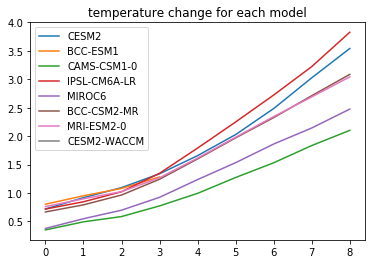

In [84]:
plt.plot(dt)
plt.title('temperature change for each model')
plt.legend(modelnames)

In [19]:
# Function to get mean and variability and their changes
def mean_var_calc(data_tmp,seas='all',weights_in=None):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .pr.mean('time'))
    
    # Take the spatial average 
    latitude=data_tmp['hist'].lat
    mu_histG = spatial_average(mu_hist,weights_in,latitude)
    mu_futrG = spatial_average(mu_futr,weights_in,latitude)

    # Calculate standard deviation of detrended series
    sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
               .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .std("time")).pr
    sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
               .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .std("time")).pr

    # Take the spatial average of variance
    # Calculate variance
    var_hist = sd_hist ** 2    
    var_histG = spatial_average(var_hist,weights_in,latitude)
    sd_histG = np.sqrt(var_histG)

    var_futr = sd_futr ** 2
    var_futrG = spatial_average(var_futr,weights_in,latitude)
    sd_futrG = np.sqrt(var_futrG)
    
    # calculate changes
    dmuG = mu_futrG/mu_histG
    dsdG = sd_futrG/sd_histG

    # Out 
    outp = xr.Dataset(
        data_vars = {'dmuG':    ([],dmuG),
                     'dsdG':    ([],dsdG)},
        )

    return(outp)

In [20]:
source_ids_areacella

['MRI-ESM2-0',
 'CESM2',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'CESM2-WACCM',
 'MIROC6',
 'CanESM5']

In [21]:
data = {}
results = {}

for mod_name in tqdm(source_ids):
    print('\n\nStarting '+mod_name+'\n')
    ds_hist = load_data(df_mon_pr, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
    ds_ssp  = load_data(df_mon_pr, mod_name, experiment_ids[1])
    try: # try getting areacella data
        ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

    except: #if not available, flag it as 0. It will use np.cos(lat)
        ds_areacella = None

    data[mod_name] = {}
    results[mod_name] = {}

    for time_slice in time_slices:
        print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
        if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
            print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
            break

       # Get corresponding temporal slice of data and stage it
        ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
        data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}


        results[mod_name]["t"+time_slice[0]] = {}

## implement this later, for now just do DJF 
#       for seas in seasons:
            # Calculate means, sds,...
        seas='DJF'
        results[mod_name]['t'+time_slice[0]][seas] = mean_var_calc(data[mod_name]['t'+time_slice[0]],seas, weights_in = ds_areacella)
        #print(seas+' processed!')

        print(time_slice[0]+'-'+time_slice[1]+' processed!')

    print(mod_name+' processed!')




Starting MRI-ESM2-0

Begin processing time slice 1991-2020
1991-2020 processed!
Begin processing time slice 2001-2030
2001-2030 processed!
Begin processing time slice 2011-2040
2011-2040 processed!
Begin processing time slice 2021-2050
2021-2050 processed!
Begin processing time slice 2031-2060
2031-2060 processed!
Begin processing time slice 2041-2070
2041-2070 processed!
Begin processing time slice 2051-2080
2051-2080 processed!
Begin processing time slice 2061-2090
2061-2090 processed!
Begin processing time slice 2071-2100
2071-2100 processed!
MRI-ESM2-0 processed!


Starting BCC-CSM2-MR

Begin processing time slice 1991-2020
1991-2020 processed!
Begin processing time slice 2001-2030
2001-2030 processed!
Begin processing time slice 2011-2040
2011-2040 processed!
Begin processing time slice 2021-2050
2021-2050 processed!
Begin processing time slice 2031-2060
2031-2060 processed!
Begin processing time slice 2041-2070
2041-2070 processed!
Begin processing time slice 2051-2080
2051-208

In [22]:
source_ids_areacella

['MRI-ESM2-0',
 'CESM2',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'CESM2-WACCM',
 'MIROC6',
 'CanESM5']

In [23]:
#results

In [24]:
# this is rather brute force, sorry
# dmuG, dsdG - also for different seasons 
dsdG_djf=results
#dsdG_jja=results.copy()
#dmuG_djf=results.copy()
#dmuG_jja=results.copy()
for model in results:
    for timeperiod in results[model]:
        dsdG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dsdG.values.item(0)
#        dsdG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dsdG.values.item(0)
#        dmuG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dmuG.values.item(0)
#        dmuG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dmuG.values.item(0)
    

In [25]:
pd.DataFrame(dsdG_djf)

,MRI-ESM2-0,BCC-CSM2-MR,CESM2,GFDL-ESM4,IPSL-CM6A-LR,CAMS-CSM1-0,CESM2-WACCM,CanESM5,MIROC6,BCC-ESM1
t1991,0.927374,0.982603,1.017618,1.035774,1.041305,0.970020,1.022184,1.041476,0.983910,0.963441
t2001,0.965627,1.012408,1.030965,1.034346,1.061704,0.998661,1.021454,1.072001,1.027627,1.002681
t2011,0.958772,1.038669,1.066046,1.030939,1.069258,1.013537,1.039816,1.079521,1.004109,1.018551
t2021,0.983005,1.057812,1.082278,1.034678,1.065308,1.025562,1.060674,1.108786,1.006428,1.032016
t2031,1.008734,1.070512,1.105388,1.057237,1.087724,1.045689,1.109779,1.127890,0.993048,NaN
t2041,1.094887,1.073504,1.121343,1.090690,1.111745,1.043397,1.121593,1.151836,1.029917,NaN
t2051,1.142753,1.082534,1.147366,1.102006,1.158009,1.049514,1.145935,1.170736,1.034896,NaN
t2061,1.158891,1.092499,1.186820,1.095531,1.194014,1.042049,1.157643,1.208483,1.038537,NaN
t2071,1.161113,1.105286,1.213157,1.099062,1.237170,1.059414,1.191385,1.239221,1.048009,NaN


In [26]:
pd.DataFrame(dsdG_djf).to_csv('dsdG_djf.csv')

In [27]:
dsdG_djf_new=pd.read_csv('dsdG_djf.csv',index_col=0)
dsdG_djf_new

,MRI-ESM2-0,BCC-CSM2-MR,CESM2,GFDL-ESM4,IPSL-CM6A-LR,CAMS-CSM1-0,CESM2-WACCM,CanESM5,MIROC6,BCC-ESM1
t1991,0.927374,0.982603,1.017618,1.035774,1.041305,0.970020,1.022184,1.041476,0.983910,0.963441
t2001,0.965627,1.012408,1.030965,1.034346,1.061704,0.998661,1.021454,1.072001,1.027627,1.002681
t2011,0.958772,1.038669,1.066046,1.030939,1.069258,1.013537,1.039816,1.079521,1.004109,1.018551
t2021,0.983005,1.057812,1.082278,1.034678,1.065308,1.025562,1.060674,1.108786,1.006428,1.032016
t2031,1.008734,1.070512,1.105388,1.057237,1.087724,1.045689,1.109779,1.127890,0.993048,NaN
t2041,1.094887,1.073504,1.121343,1.090690,1.111745,1.043397,1.121593,1.151836,1.029917,NaN
t2051,1.142753,1.082534,1.147366,1.102006,1.158009,1.049514,1.145935,1.170736,1.034896,NaN
t2061,1.158891,1.092499,1.186820,1.095531,1.194014,1.042049,1.157643,1.208483,1.038537,NaN
t2071,1.161113,1.105286,1.213157,1.099062,1.237170,1.059414,1.191385,1.239221,1.048009,NaN


In [28]:
dsdG_djf=dsdG_djf_new.to_dict()

In [29]:
dsdG_djf_np=np.zeros((len(time_slices),len(dsdG_djf)))*np.nan 

In [30]:
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in dsdG_djf[model]:
        dsdG_djf_np[timecount,modelcount]=dsdG_djf[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

In [31]:
dsdG_djf_np

array([[0.97001951, 1.0413053 , 0.92737365, 1.0221839 , 1.04147601,
        1.03577399, 1.01761818, 0.98390967, 0.98260308, 0.96344096],
       [0.99866134, 1.06170416, 0.9656269 , 1.02145362, 1.07200062,
        1.0343461 , 1.03096521, 1.02762699, 1.01240815, 1.00268099],
       [1.01353749, 1.06925786, 0.95877194, 1.03981602, 1.07952094,
        1.03093898, 1.06604552, 1.00410914, 1.03866912, 1.01855125],
       [1.02556207, 1.06530845, 0.98300475, 1.06067407, 1.10878611,
        1.03467751, 1.08227813, 1.00642753, 1.05781245, 1.03201613],
       [1.04568893, 1.08772409, 1.00873399, 1.10977948, 1.12788951,
        1.05723727, 1.10538793, 0.99304754, 1.07051213,        nan],
       [1.04339748, 1.11174512, 1.0948875 , 1.121593  , 1.1518364 ,
        1.09069026, 1.12134326, 1.02991724, 1.07350369,        nan],
       [1.04951387, 1.15800941, 1.14275289, 1.14593542, 1.17073643,
        1.10200596, 1.1473664 , 1.03489614, 1.08253419,        nan],
       [1.04204886, 1.19401419, 1.1588907

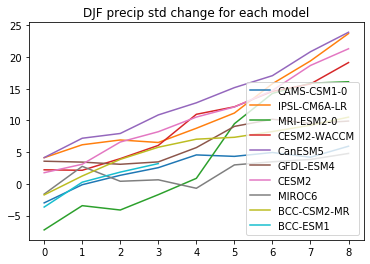

In [32]:
plt.plot((dsdG_djf_np-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(modelnames)